In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as sts
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### Data import

In [2]:
data = load_breast_cancer(as_frame=True)

### Data preparation

In [3]:
# (separate) X and y
X = data.data
y = data.target

In [4]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, shuffle=True)

##### To avoid information leakage, feature selection will be performed only on the training set.

### Feature selection

- Variance threshold

In [5]:
# remove features with a low variance
selector = VarianceThreshold(threshold=.25)   # drop features in which similarity is 75% or higher
selection = selector.fit(X_train)   # fit the selector
sel_index = selection.get_support()   # get the results for the features
selected_features_VT = X_train.columns[sel_index]   # get the names of the selected features

In [6]:
selected_features_VT

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'texture error', 'perimeter error', 'area error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area'],
      dtype='object')

<br>

#### Univariate feature selection

- Correlation analysis

In [7]:
# calculate correlation coefficient and p-value with point biserial correlation
feature_list = []
PB_corr = []
PB_sign = []

for c in X_train.columns:
    feature_list.append(c)   # add feature names to the list
    PB_corr.append(sts.pointbiserialr(y_train, X_train[c])[0])   # only the correlation coefficients
    PB_sign.append(sts.pointbiserialr(y_train, X_train[c])[1])   # only the p-values

# create a df with the correlation results
correlation_df = pd.DataFrame({'feature':feature_list, 'correlation':PB_corr, 'significance':PB_sign})   # create a df with the results
correlation_df.set_index('feature', inplace=True)   # set feature names as index for the heatmap

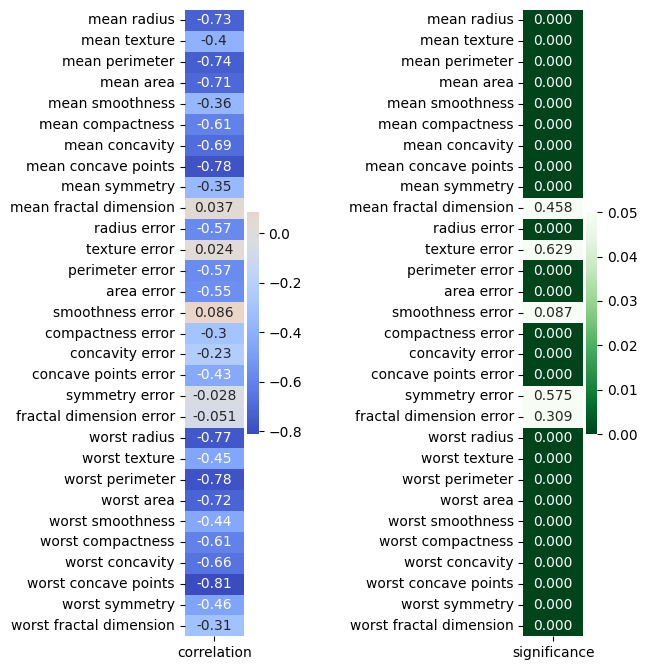

In [8]:
# visualize the correlation results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,11), width_ratios=(1,1))
fig.tight_layout(pad=16)

# correlation heatmap
sns.heatmap(data=correlation_df[['correlation']], annot=True, cmap='coolwarm', center=0, ax=ax[0])
ax[0].set_ylabel('')

# significance heatmap
sns.heatmap(data=correlation_df[['significance']], annot=True, fmt='.3f', cmap='Greens_r', vmax=0.05, ax=ax[1])
ax[1].set_ylabel('');

##### In most cases, significance is very high, therefore selecting all the significant features wouldn't drasticly reduce the number of features.

In [9]:
# select features with a relativily high correlation
selected_features_PBcorr = correlation_df[correlation_df['correlation'].abs() > 0.65]   # selection
selected_features_PBcorr = selected_features_PBcorr.sort_values('correlation')   # ordering

In [10]:
selected_features_PBcorr

,correlation,significance
feature,,
worst concave points,-0.812227,9.958450e-95
mean concave points,-0.783217,9.542099e-84
worst perimeter,-0.777190,1.121979e-81
worst radius,-0.770776,1.523739e-79
mean perimeter,-0.744040,2.379762e-71
mean radius,-0.731126,9.496150e-68
worst area,-0.719659,1.009960e-64
mean area,-0.708127,7.924300e-62
mean concavity,-0.689095,2.394478e-57


- Mutual information score

In [11]:
# select features with high mutual information
MIscores = mutual_info_classif(X_train, y_train, random_state=101)
MI_results = pd.DataFrame({'feature':X_train.columns, 'MI_score':MIscores})   # create a df with the MI scores

# calculate median MI score
MI_median = MI_results['MI_score'].median()

# features that have a MI score higher then the median
selected_features_MI = MI_results[MI_results['MI_score'] > MI_median]   # selection
selected_features_MI = selected_features_MI.sort_values('MI_score', ascending=False)   # descending order

In [12]:
selected_features_MI

,feature,MI_score
22,worst perimeter,0.480664
27,worst concave points,0.468007
23,worst area,0.462424
20,worst radius,0.458436
7,mean concave points,0.441503
2,mean perimeter,0.413537
0,mean radius,0.385695
3,mean area,0.382068
6,mean concavity,0.367583
26,worst concavity,0.350864


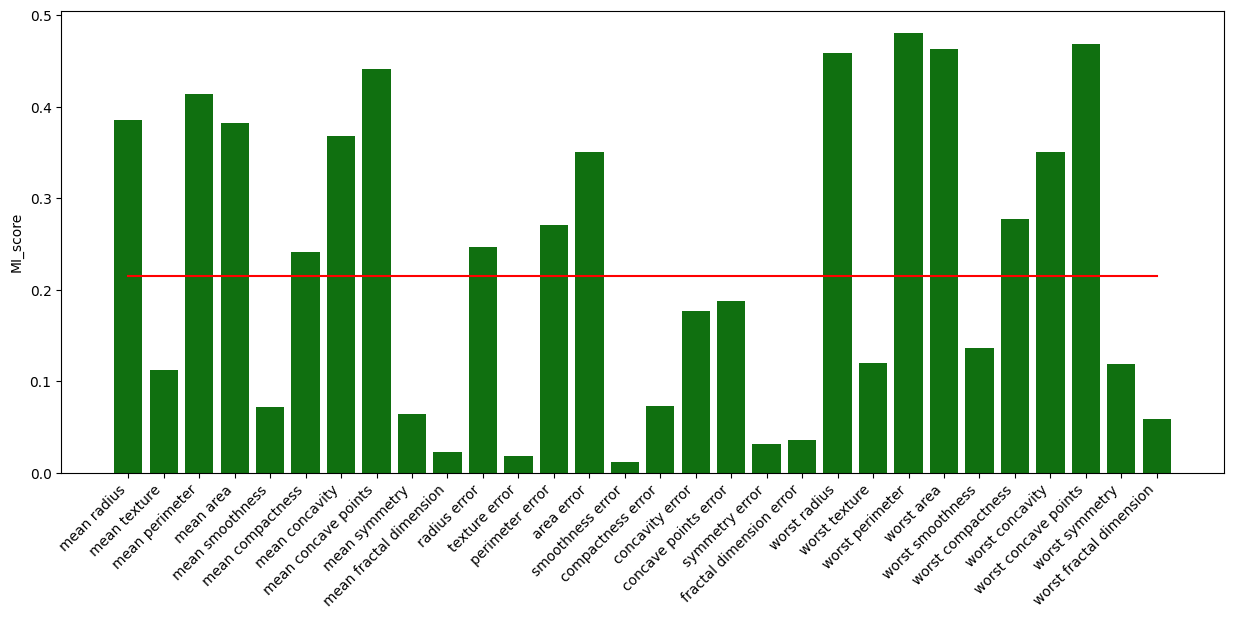

In [13]:
# visualize the above results
plt.figure(figsize=(15,6))
sns.barplot(data=MI_results, x='feature', y='MI_score', color='green')
sns.lineplot(data=MI_results, x='feature', y=MI_results['MI_score'].median(), c='red')   # to show the median MI score
plt.xticks(rotation=45, ha='right')
plt.xlabel('');

- F-score

In [14]:
# feature selection via F-scores
Fscores = f_classif(X_train, y_train)
Fscore_results = pd.DataFrame({'feature':X.columns, 'F_score':Fscores[0], 'p_value':Fscores[1]})   # create a df with the F-scores

In [15]:
# number of features that are significant
len(Fscore_results[Fscore_results['p_value'] < 0.0001])

25

In [16]:
# features that are insignificant
Fscore_results[Fscore_results['p_value'] > 0.05]

,feature,F_score,p_value
9,mean fractal dimension,0.551365,0.458201
11,texture error,0.234402,0.628547
14,smoothness error,2.944166,0.086970
18,symmetry error,0.315327,0.574747
19,fractal dimension error,1.037529,0.309019


##### Since most of the features show very strong significance, the number of features cannot be reduced based on this parameter.
##### There are 5 insignificant features that are exactly the same as the ones in the correlation test.

In [17]:
# calculate median F-score
Fscore_median = Fscore_results['F_score'].median()

# select features with an F-score higher then the median
selected_features_Fscore = Fscore_results[Fscore_results['F_score'] > Fscore_median]   # selection
selected_features_Fscore = selected_features_Fscore.sort_values('F_score', ascending=False)   # descending order

In [18]:
selected_features_Fscore

,feature,F_score,p_value
27,worst concave points,767.720439,9.958450e-95
7,mean concave points,628.391414,9.542099e-84
22,worst perimeter,604.060947,1.121979e-81
20,worst radius,579.600781,1.523739e-79
2,mean perimeter,491.088539,2.379762e-71
0,mean radius,454.781585,9.496150e-68
23,worst area,425.420961,1.009960e-64
3,mean area,398.294193,7.924300e-62
6,mean concavity,358.072346,2.394478e-57
26,worst concavity,302.956310,8.423243e-51


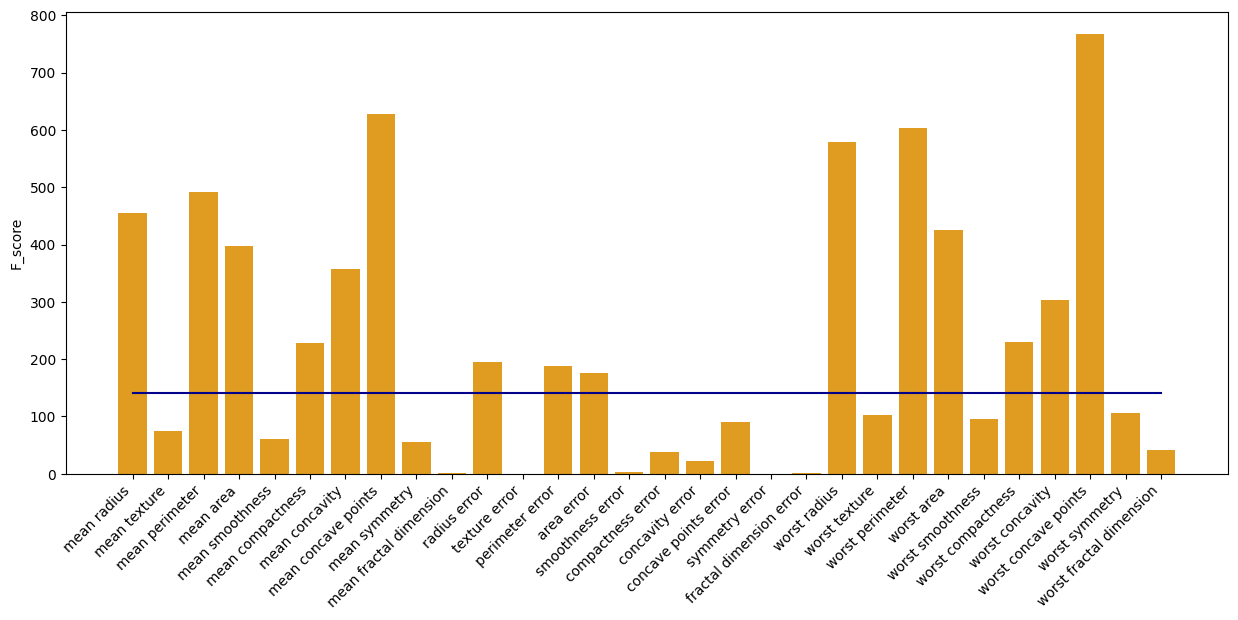

In [19]:
# visualize the above results
plt.figure(figsize=(15,6))
sns.barplot(data=Fscore_results, x='feature', y='F_score', color='orange')
sns.lineplot(data=Fscore_results, x='feature', y=Fscore_results['F_score'].median(), c='darkblue')   # to show the median MI score
plt.xticks(rotation=45, ha='right')
plt.xlabel('');

<br>

#### Beyond univariate feature selection - model-based methods to evaluate feature importance

In [20]:
# scale the data before fitting the models
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)

- Use SelectFromModel to find relevant features

    - Logistic regression

In [21]:
# feature importance with logistic regression
LR_model = LogisticRegression(max_iter=10000, C=0.01)
LR_model.fit(X_train_sc, y_train)   # prefit the model
SFM_LR = SelectFromModel(LR_model, prefit=True, threshold='median')   # select features with an importance value higher than the median 
sel_index_LR = SFM_LR.get_support()   # get the results for the features
selected_features_LR = X_train.columns[sel_index_LR]   # get the name of the features

In [22]:
selected_features_LR

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean concavity', 'mean concave points', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry'],
      dtype='object')

In [23]:
# create a dataframe with the coefficients for each feature
coefs_LR = SFM_LR.estimator.coef_   # get the coefficients
SFM_results = pd.DataFrame({'feature':X_train.columns, 'coefs_LR':coefs_LR[0]})   # create df

    - Support vector machine

In [24]:
SVC_model = SVC(kernel='linear', C=0.01)   # it doesn't work with 'rbf' -> look deeper into it OR test SVC with linear kernel for the model selection as well
SVC_model.fit(X_train_sc, y_train)
SFM_SVC = SelectFromModel(SVC_model, prefit=True, threshold='median')
sel_index_SVC = SFM_SVC.get_support()
selected_features_SVC = X_train.columns[sel_index_SVC]

In [25]:
selected_features_SVC

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean concavity', 'mean concave points', 'radius error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area', 'worst smoothness',
       'worst concavity', 'worst concave points', 'worst symmetry'],
      dtype='object')

In [26]:
coefs_SVC = SFM_SVC.estimator.coef_
SFM_results['coefs_SVC'] = coefs_SVC[0]

    - Random Forest

In [27]:
# feature importance with random forest
RF_model = RandomForestClassifier(n_estimators=200)
RF_model.fit(X_train_sc, y_train)
SFM_RF = SelectFromModel(RF_model, prefit=True, threshold='median')
sel_index_RF = SFM_RF.get_support()
selected_features_RF = X_train.columns[sel_index_RF]

In [28]:
selected_features_RF

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean concavity', 'mean concave points', 'perimeter error',
       'area error', 'worst radius', 'worst texture', 'worst perimeter',
       'worst area', 'worst smoothness', 'worst concavity',
       'worst concave points'],
      dtype='object')

In [29]:
# get feature importance and add it to the SFM_results df
f_imps_RF = SFM_RF.estimator.feature_importances_
SFM_results['f_imps_RF'] = f_imps_RF

    - Gradient Boosting

In [30]:
GB_model = GradientBoostingClassifier(n_estimators=200)   # try with different numbers of estimators and see the difference
GB_model.fit(X_train_sc, y_train)
SFM_GB = SelectFromModel(GB_model, prefit=True, threshold='median')
sel_index_GB = SFM_GB.get_support()
selected_features_GB = X_train.columns[sel_index_GB]

In [31]:
selected_features_GB

Index(['mean texture', 'mean compactness', 'mean concave points',
       'texture error', 'area error', 'smoothness error', 'concavity error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst compactness',
       'worst concave points', 'worst symmetry'],
      dtype='object')

In [32]:
f_imps_GB = SFM_GB.estimator.feature_importances_
SFM_results['f_imps_GB'] = f_imps_GB

In [33]:
SFM_results

,feature,coefs_LR,coefs_SVC,f_imps_RF,f_imps_GB
0,mean radius,-0.203864,-0.139576,0.049766,1.245381e-03
1,mean texture,-0.154682,-0.134365,0.016004,1.824004e-02
2,mean perimeter,-0.202591,-0.136460,0.059872,4.227848e-04
3,mean area,-0.187284,-0.135415,0.040718,2.129029e-04
4,mean smoothness,-0.081415,-0.057230,0.006667,6.371180e-05
5,mean compactness,-0.102722,-0.015199,0.008413,2.364947e-03
6,mean concavity,-0.150253,-0.122360,0.049304,5.397820e-04
7,mean concave points,-0.206678,-0.177349,0.115664,2.081725e-01
8,mean symmetry,-0.085826,-0.073254,0.004076,1.040216e-03
9,mean fractal dimension,0.083966,0.104697,0.002982,1.702936e-07


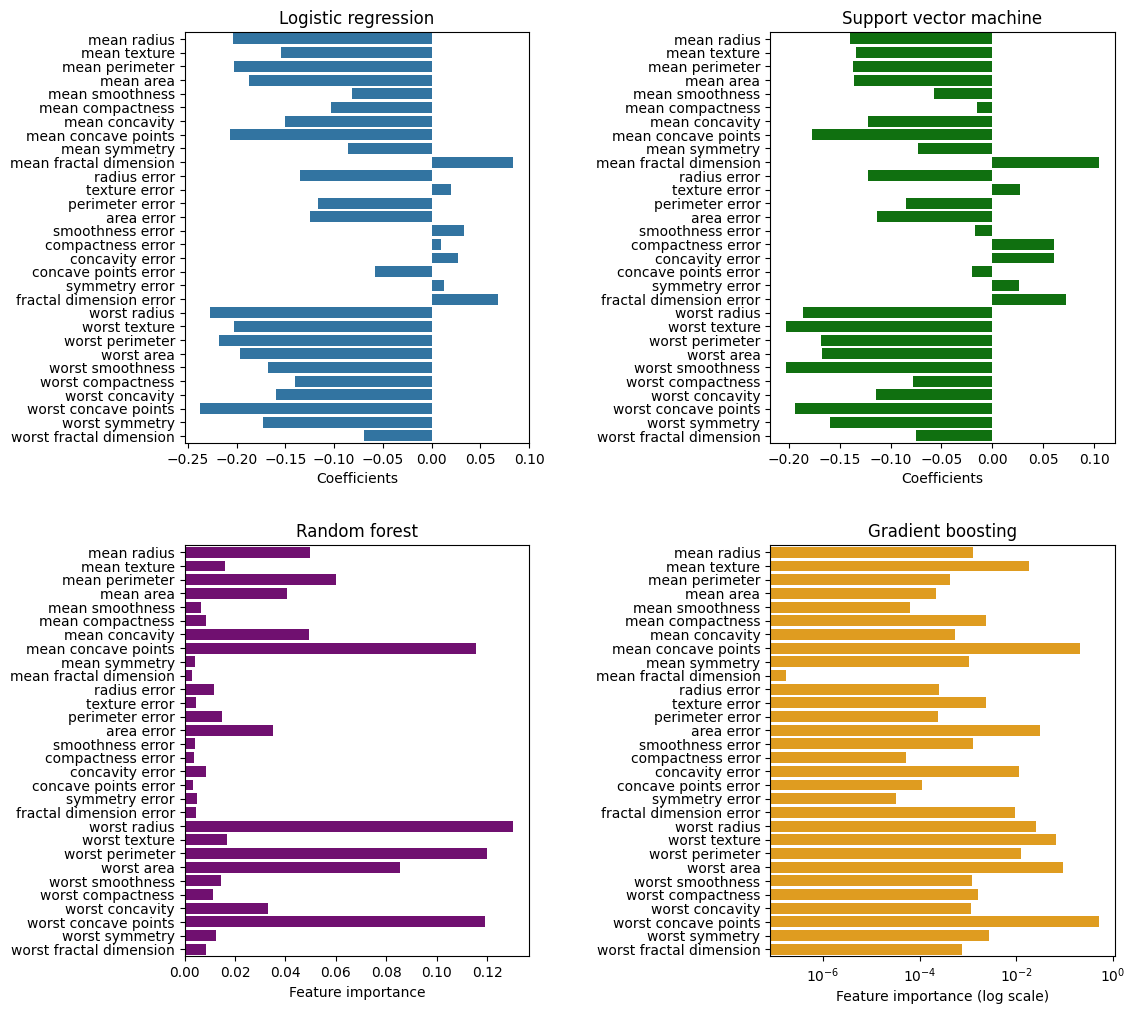

In [41]:
# visualize the above results
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
plt.subplots_adjust(wspace=0.7, hspace=0.25)

# logistic regression
sns.barplot(data=SFM_results, x='coefs_LR', y='feature', ax=ax[0][0])
ax[0][0].set_ylabel('')
ax[0][0].set_xlabel('Coefficients')
ax[0][0].set_title('Logistic regression')

# support vector machine
sns.barplot(data=SFM_results, x='coefs_SVC', y='feature', ax=ax[0][1], color='green')
ax[0][1].set_ylabel('')
ax[0][1].set_xlabel('Coefficients')
ax[0][1].set_title('Support vector machine')

# random forest
sns.barplot(data=SFM_results, x='f_imps_RF', y='feature', ax=ax[1][0], color='purple')
ax[1][0].set_ylabel('')
ax[1][0].set_xlabel('Feature importance')
ax[1][0].set_title('Random forest')

# gradient boosting
sns.barplot(data=SFM_results, x='f_imps_GB', y='feature', ax=ax[1][1], color='orange')
ax[1][1].set_ylabel('')
ax[1][1].set_xlabel('Feature importance (log scale)')
ax[1][1].set_title('Gradient boosting')
ax[1][1].set_xscale('log')   # set the scale to logarithmic

##### Since some feature importance scores from gradient boosting show much higher values (worst concave points, mean concave points) than the others, many of the lower ones were invisible in the graph. Therefore, the scale is displayed as logarithmic.

<br>

    - LASSO/L1 regularization to find the most important features

In [35]:
# logistic regression with L1 regularization
LR_model_L1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000)
LR_model_L1.fit(X_train_sc, y_train)
SFM_LR_L1 = SelectFromModel(LR_model_L1, prefit=True)
sel_index_LR_L1 = SFM_LR_L1.get_support()
selected_features_L1reg = X_train.columns[sel_index_LR_L1]

In [36]:
selected_features_L1reg

Index(['mean concavity', 'mean concave points', 'mean fractal dimension',
       'radius error', 'compactness error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst area', 'worst smoothness',
       'worst concave points', 'worst symmetry'],
      dtype='object')

In [38]:
# get the coefficients for each feature
coefs_L1reg = SFM_LR_L1.estimator.coef_   # get the coefs
L1reg_df = pd.DataFrame({'feature':X_train.columns, 'coefs_L1reg':coefs_L1reg[0]})   # create df

Text(0.5, 1.0, 'L1 regularization')

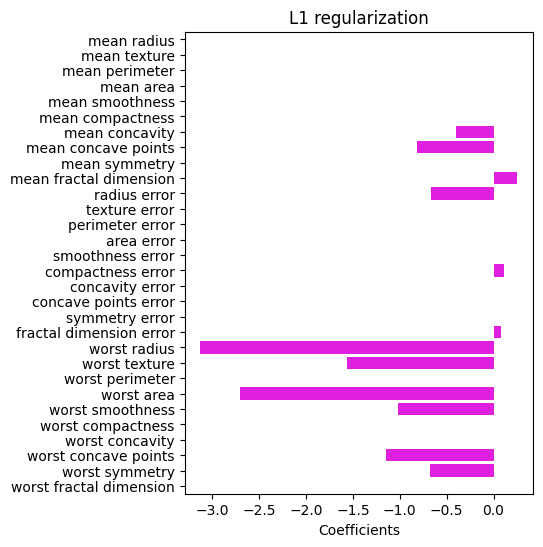

In [39]:
# visualize the results of L1 regularization
plt.figure(figsize=(4.5,6))
sns.barplot(data=L1reg_df, x='coefs_L1reg', y='feature', color='magenta')
plt.ylabel('')
plt.xlabel('Coefficients')
plt.title('L1 regularization')